In [6]:

# Import required libraries
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

# Dataset path and selection parameters
dataset = "/home/lucian/University/MSc-Courses/BiometricSystems/data/"
selected_person = "007"
selected_hand = "r"
selected_spectrum = "940"

# Load matching image files
pattern = f"{selected_person}_{selected_hand}_{selected_spectrum}_*.jpg"
matching_files = glob.glob(dataset + pattern)
selected_files = glob.glob(dataset + pattern)[:3]  # Load first 6 images for demonstration


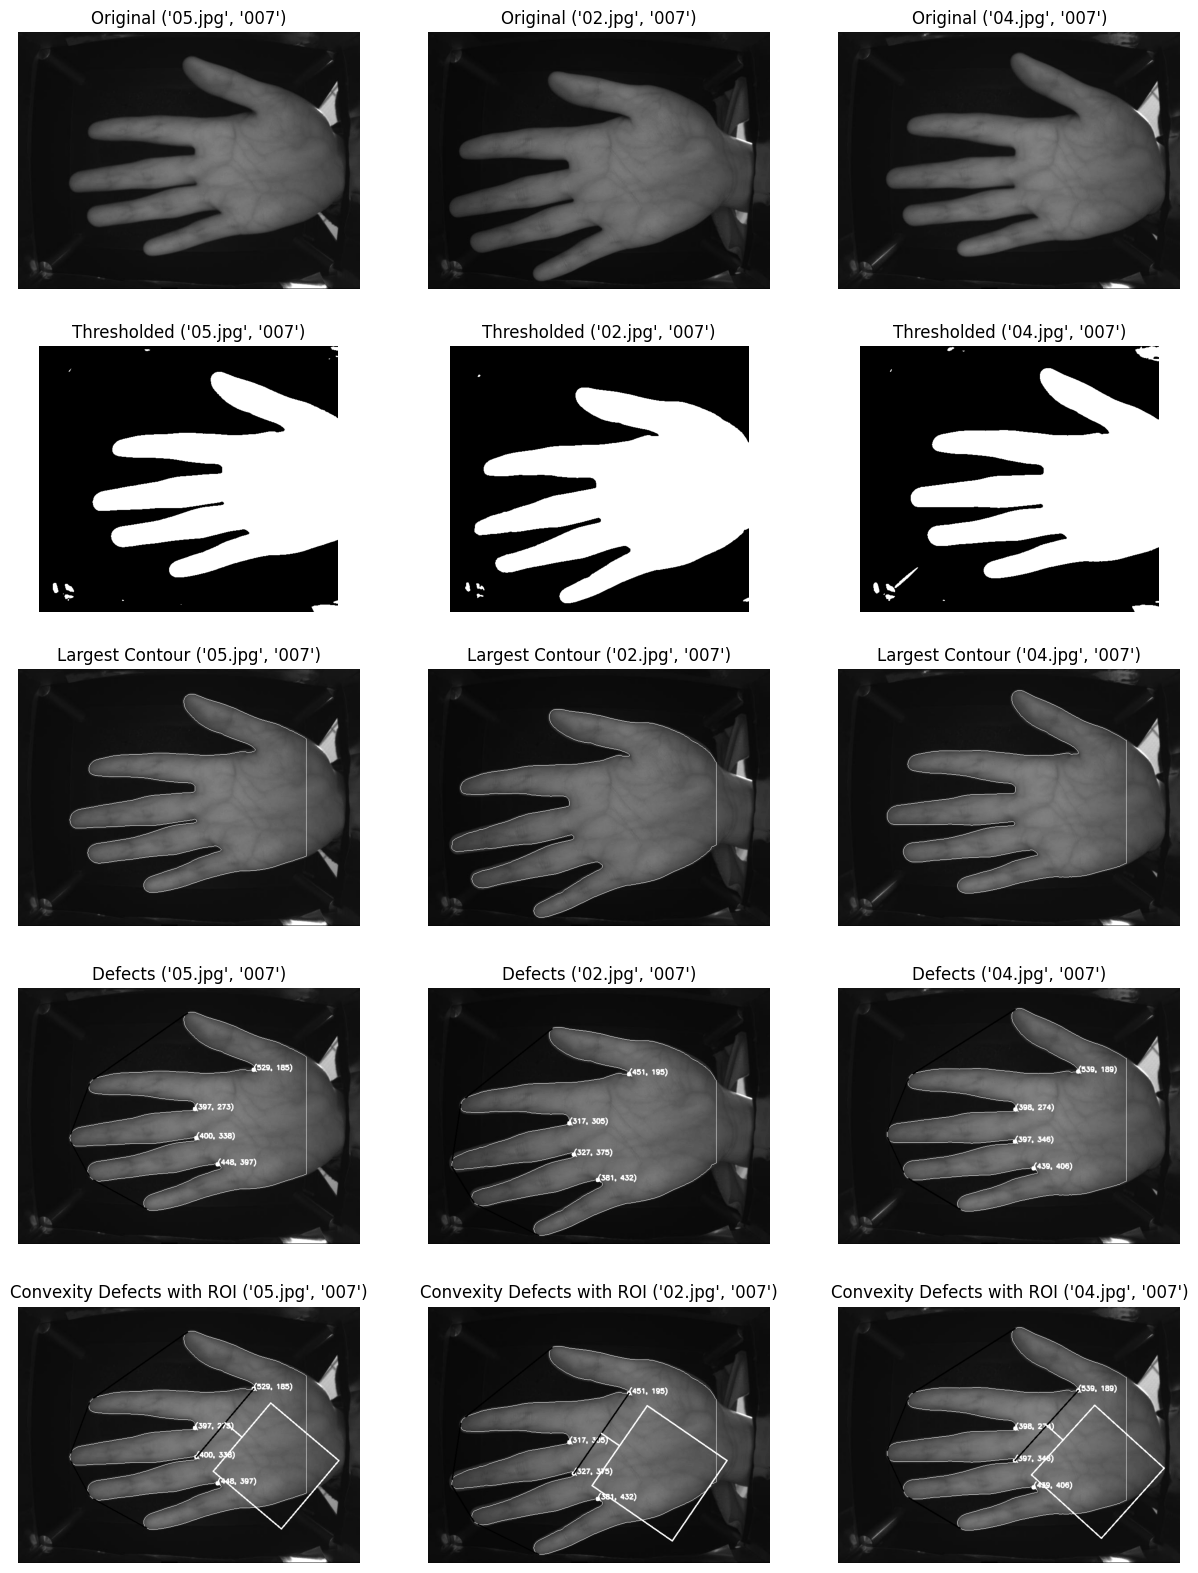

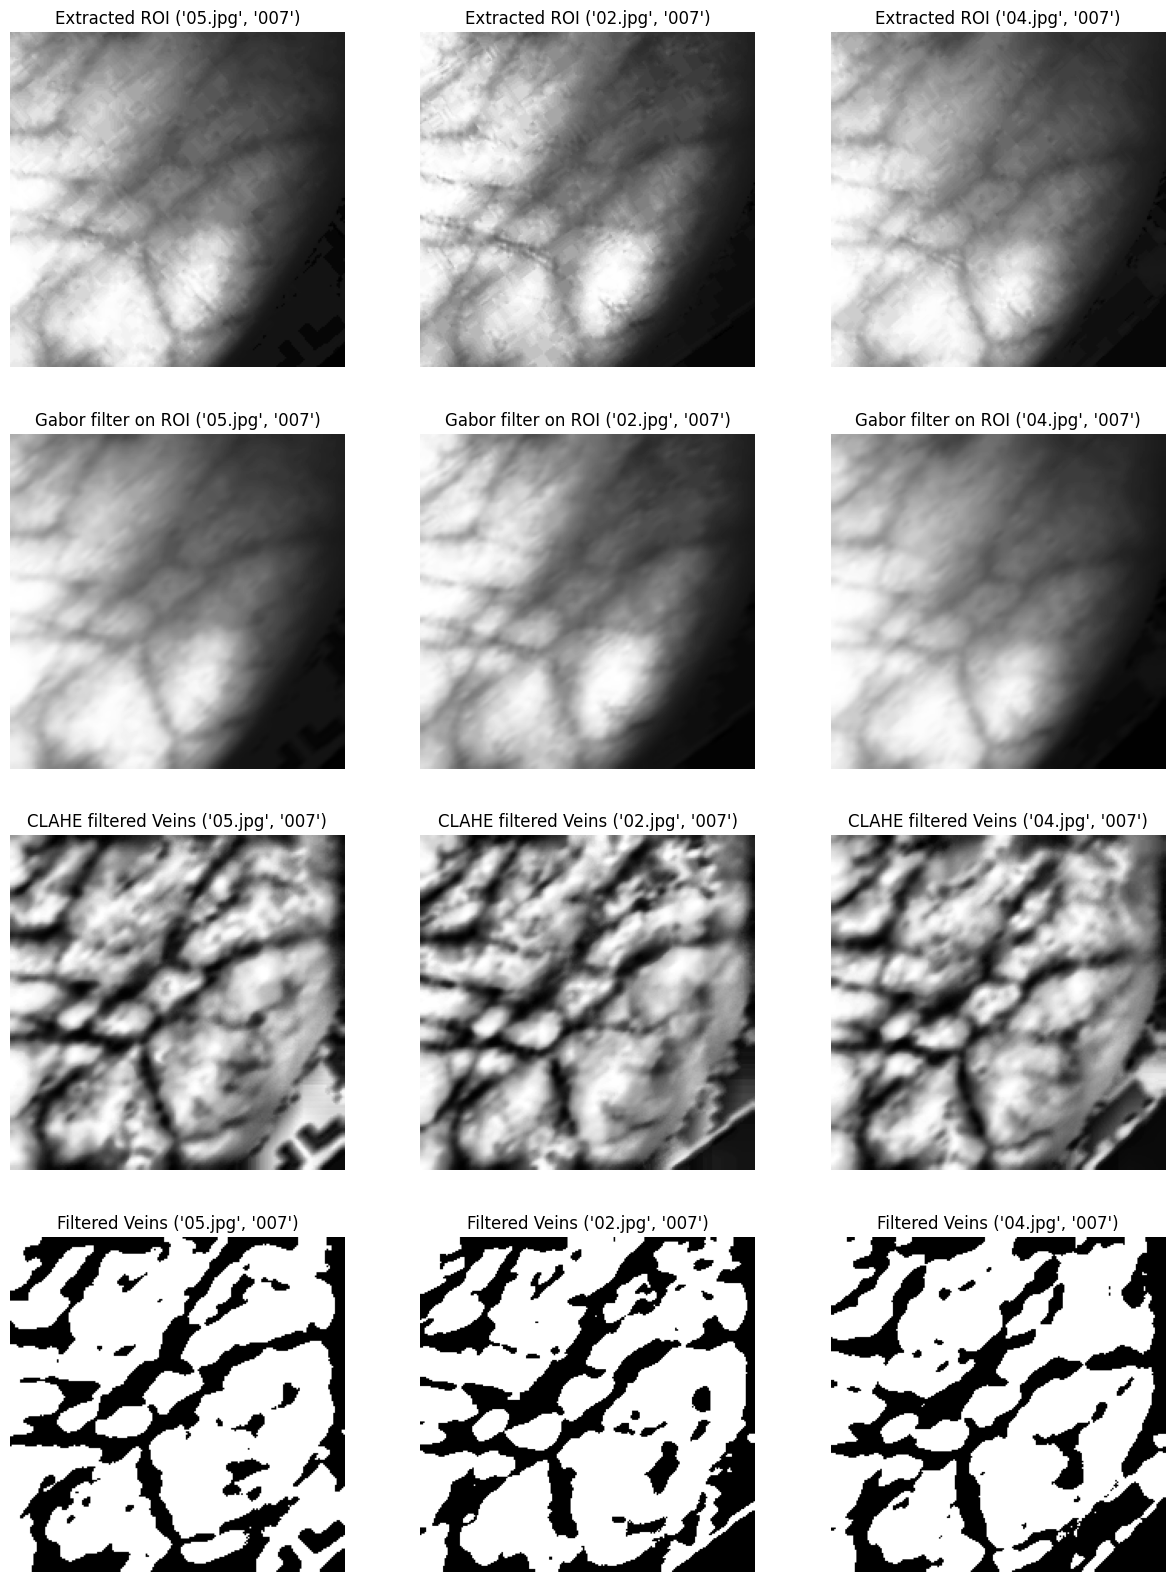

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))
fig2, axes2 = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
for idx, file_path in enumerate(selected_files):
    person_id, hand, spectrum, number = (file_path.split("/")[-1]).split("_")
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    # Work data preprocessing
    cropped_image = image[:, :image.shape[1] - 120]
    blurred = cv2.GaussianBlur(cropped_image, (5, 5), 0)
    _, thresholded = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    # Original image
    axes[0, idx].imshow(image, cmap='gray')
    axes[0, idx].set_title(f"Original {number, person_id}")
    axes[0, idx].axis('off')

    # Thresholded image
    axes[1, idx].imshow(thresholded, cmap='gray')
    axes[1, idx].set_title(f"Thresholded {number, person_id}")
    axes[1, idx].axis('off')

    # Contouring hand
    image_with_contours = np.copy(image)
    cv2.drawContours(image_with_contours, [largest_contour], -1, (255, 255, 255), 1)

    # Image with contours
    axes[2, idx].imshow(image_with_contours, cmap='gray')
    axes[2, idx].set_title(f"Largest Contour {number, person_id}")
    axes[2, idx].axis('off')

    # Calculate convexity defects
    defects_image = np.copy(image_with_contours)
    hull = cv2.convexHull(largest_contour, returnPoints=False)
    defects = cv2.convexityDefects(largest_contour, hull)

    # Sort defects based on depth
    defects = sorted(defects, key=lambda x: x[0, 3], reverse=True)

    # Draw only the first 4 defects on the defects_image
    for i in range(min(4, len(defects))):
        s, e, f, d = defects[i][0]
        start = tuple(largest_contour[s][0])
        end = tuple(largest_contour[e][0])
        far = tuple(largest_contour[f][0])
        cv2.line(defects_image, start, end, [0, 255, 0], 2)
        cv2.circle(defects_image, far, 5, [255, 255, 255], -1)

        # Add label to far points with their X and Y coordinates
        label = f"({far[0]}, {far[1]})"
        cv2.putText(defects_image, label, far, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Defects image
    axes[3, idx].imshow(defects_image, cmap='gray')
    axes[3, idx].set_title(f"Defects {number, person_id}")
    axes[3, idx].axis('off')

    # Choose the far points with the lowest and third lowest y-coordinates
    far_points = [tuple(largest_contour[defects[i][0][2]][0]) for i in range(4)]
    far_points = sorted(far_points, key=lambda point: point[1])  # Sort by y-coordinate
    first_defect_far, third_defect_far = far_points[0], far_points[2]

    # Draw a line between the first and third defects
    cv2.line(defects_image, first_defect_far, third_defect_far, [0, 0, 255], 2)

    # Calculate the midpoint of the line
    midpoint = ((first_defect_far[0] + third_defect_far[0]) // 2, (first_defect_far[1] + third_defect_far[1]) // 2)

    # Calculate the direction vector (dx, dy) of the line
    dx = third_defect_far[0] - first_defect_far[0]
    dy = third_defect_far[1] - first_defect_far[1]

    # Normalize the direction vector
    length = np.sqrt(dx**2 + dy**2)
    dx /= length
    dy /= length

    # Calculate the coordinates of the perpendicular line
    x_perpendicular = int(midpoint[0] + 50 * dy)
    y_perpendicular = int(midpoint[1] - 50 * dx)

    # Draw the perpendicular line
    cv2.line(defects_image, midpoint, (x_perpendicular, y_perpendicular), [255, 0, 0], 2)

    # Calculate the length of the side of the square
    length = int(np.sqrt((third_defect_far[0] - first_defect_far[0])**2 + (third_defect_far[1] - first_defect_far[1])**2))

    # Calculate the coordinates of the square vertices
    square_vertices = [
        (x_perpendicular + 50, y_perpendicular),
        (x_perpendicular + 50, y_perpendicular - length),
        (x_perpendicular + 50 + length, y_perpendicular - length),
        (x_perpendicular + 50 + length, y_perpendicular)
    ]

    # Calculate the angle of rotation
    angle = np.arctan2(-dy, dx) * 180 / np.pi

    # Create a rotation matrix
    midpoint = (int(midpoint[0]), int(midpoint[1]))
    rotation_matrix = cv2.getRotationMatrix2D(midpoint, angle, scale=1)

    # Apply the rotation to the square vertices
    rotated_square_vertices = cv2.transform(np.array([square_vertices], dtype=np.float32), rotation_matrix).squeeze().astype(np.int32)

    # Calculate the new starting point for the square
    start_point = (first_defect_far[0] - rotated_square_vertices[0][0], first_defect_far[1] - rotated_square_vertices[0][1])

    # Translate the rotated square to the new starting point
    translated_square_vertices = rotated_square_vertices + start_point

    # Calculate the direction vector (dx_perpendicular, dy_perpendicular) of the perpendicular line
    dx_perpendicular = x_perpendicular - midpoint[0]
    dy_perpendicular = y_perpendicular - midpoint[1]

    # Normalize the direction vector
    length_perpendicular = np.sqrt(dx_perpendicular**2 + dy_perpendicular**2)
    dx_perpendicular /= length_perpendicular
    dy_perpendicular /= length_perpendicular

    # Calculate the translation vector along the perpendicular line
    translation_vector = (int(50 * dx_perpendicular), int(50 * dy_perpendicular))

    # Translate the rotated and aligned square vertices
    translated_along_perpendicular = translated_square_vertices + translation_vector

    # Draw the rotated, aligned, and translated square
    cv2.polylines(defects_image, [translated_along_perpendicular], isClosed=True, color=[255, 0, 0], thickness=2)

    # Image with contours and convexity defects
    axes[4, idx].imshow(defects_image, cmap='gray')
    axes[4, idx].set_title(f"Convexity Defects with ROI {number, person_id}")
    axes[4, idx].axis('off')

    # Convert the lists to NumPy arrays
    translated_along_perpendicular = np.array(translated_along_perpendicular, dtype=np.float32)
    square_vertices = np.array(square_vertices, dtype=np.float32)

    # Ensure a consistent order of points for perspective transformation
    rectified_order = np.array([[0, 0], [length, 0], [length, length], [0, length]], dtype=np.float32)

    # Perspective transformation to rectify the rotated square to a rectangle
    transform_matrix = cv2.getPerspectiveTransform(translated_along_perpendicular, rectified_order)
    rectified_image = cv2.warpPerspective(image, transform_matrix, (length, length))
    rectified_image_equalized = cv2.equalizeHist(rectified_image)

    # Image with Extracted ROI and no changes
    axes2[0, idx].imshow(rectified_image_equalized, cmap='gray')
    axes2[0, idx].set_title(f"Extracted ROI {number, person_id}")
    axes2[0, idx].axis('off')

    g_kernel_size = 5
    g_sigma = 2.5
    g_theta = np.pi / 3
    g_lambda = 8.0
    g_gamma = 0.4
    g_psi = 0.0

    # Create the Gabor kernel
    gabor_kernel = cv2.getGaborKernel((g_kernel_size, g_kernel_size), g_sigma, g_theta, g_lambda, g_gamma, g_psi, ktype=cv2.CV_32F)
    filtered_veins = cv2.filter2D(rectified_image_equalized, cv2.CV_32F, gabor_kernel)

    # Normalize the filtered image
    filtered_veins = cv2.normalize(filtered_veins, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    # Image with extracted ROI and gabor filter applied
    axes2[1, idx].imshow(filtered_veins, cmap='gray')
    axes2[1, idx].set_title(f"Gabor filter on ROI {number, person_id}")
    axes2[1, idx].axis('off')

    # Apply thresholding and CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(2, 2))
    clahe_veins = clahe.apply(filtered_veins)
    clahe_blurred = cv2.GaussianBlur(clahe_veins, (5, 5), 0) # gaussian blur
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4, 4))
    clahe_veins = clahe.apply(clahe_blurred)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_veins = clahe.apply(clahe_veins)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
    clahe_veins = clahe.apply(clahe_veins)

    # CLAHE veins
    axes2[2, idx].imshow(clahe_veins, cmap='gray')
    axes2[2, idx].set_title(f"CLAHE filtered Veins {number, person_id}")
    axes2[2, idx].axis('off')

    _, binary_veins = cv2.threshold(clahe_veins, 110, 255, cv2.THRESH_BINARY)

    # Filtered veins
    axes2[3, idx].imshow(binary_veins, cmap='gray')
    axes2[3, idx].set_title(f"Filtered Veins {number, person_id}")
    axes2[3, idx].axis('off')